In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from joblib import dump, load

In [3]:
pd.set_option("display.max_columns", None)



In [4]:
data_path = '../data/uci_data.xls'

df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)
df = df.rename(columns={'PAY_0': 'PAY_1'})

# I set all invalid values to 'other'
df.loc[~(df['EDUCATION'].isin([1, 2, 3, 4])), 'EDUCATION'] = 4
df.loc[~(df['MARRIAGE'].isin([1, 2, 3])), 'MARRIAGE'] = 3

# PAY_* fuera de rango
paux = ~(df['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))
for i in range(2, 7):
    paux = paux | ~(df['PAY_' + str(i)].isin([-1,0,1,2,3,4,5,6,7,8,9]))
    
df = df[~paux]

categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

df[categorical_cols] = df[categorical_cols].astype('category')

In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train = train.drop(columns=("default payment next month"))
y_train = train[["default payment next month"]]
X_test = test.drop(columns=("default payment next month"))
y_test = test[["default payment next month"]]

In [6]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

categorical_features = X_train.select_dtypes(include='category').columns.tolist()

In [7]:
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Apply one-hot encoder to each column with categorical data
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = pd.DataFrame(ohe.fit_transform(X_train[categorical_features]))
ohe_test = pd.DataFrame(ohe.transform(X_test[categorical_features]))

# One-hot encoding removed index; put it back
ohe_train.index = X_train.index
ohe_test.index = X_test.index
ohe_train.columns = ohe.get_feature_names(categorical_features)
ohe_test.columns = ohe.get_feature_names(categorical_features)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_features, axis=1)
num_X_test = X_test.drop(categorical_features, axis=1)

# Add one-hot encoded columns to numerical features
ohe_X_train = pd.concat([num_X_train, ohe_train], axis=1)
ohe_X_test = pd.concat([num_X_test, ohe_test], axis=1)
ohe_X_train

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29366,-0.831928,-1.210027,-0.650467,-0.657047,-0.504071,-0.479666,-0.628858,-0.629335,-0.239417,-0.255924,-0.254647,-0.300406,-0.301686,-0.285243,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29255,-0.831928,-1.102875,-0.157251,-0.142776,-0.137837,-0.079685,-0.040434,-0.000228,-0.253209,-0.203610,-0.202398,-0.237792,-0.200430,-0.177269,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21187,1.905457,-0.352811,-0.069652,-0.048205,-0.080130,-0.070968,0.000988,0.059047,-0.186883,-0.160163,-0.145605,-0.133652,-0.135772,1.912824,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15756,-0.753717,-1.317179,-0.008904,0.007749,0.022902,-0.077687,-0.331155,-0.291855,-0.188563,-0.206355,-0.142823,-0.133652,-0.135642,-0.249003,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7506,-0.597295,0.182949,0.242721,0.070819,-0.060417,0.058625,0.157899,0.129138,-0.367211,-0.223722,-0.032021,-0.068565,-0.071113,-0.198864,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15245,-0.597295,0.182949,-0.420787,-0.396635,-0.334970,-0.289140,-0.239521,-0.224756,-0.248532,-0.108588,-0.242152,-0.231283,-0.329748,-0.232979,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27563,-1.066561,1.897381,-0.544664,-0.539027,-0.537056,-0.498211,-0.472670,-0.450180,-0.290510,-0.245842,-0.242152,-0.283353,-0.284487,-0.270540,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6915,-0.44087

### Logistic Regression

In [8]:
lg_clf = LogisticRegression(solver='liblinear',
                         class_weight='balanced', 
                         max_iter=5000)

In [9]:
%%time
lg_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 231 ms, sys: 7.96 ms, total: 239 ms
Wall time: 238 ms


LogisticRegression(class_weight='balanced', max_iter=5000, solver='liblinear')

In [10]:
dump(lg_clf, 'lr.joblib')

['lr.joblib']

In [11]:
print(metrics.classification_report(y_train, lg_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.88      0.85      0.86     14480
     default       0.54      0.60      0.57      4271

    accuracy                           0.79     18751
   macro avg       0.71      0.73      0.72     18751
weighted avg       0.80      0.79      0.80     18751



In [12]:
print(metrics.classification_report(y_test, lg_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.87      0.86      0.86      3574
     default       0.56      0.59      0.58      1114

    accuracy                           0.79      4688
   macro avg       0.72      0.72      0.72      4688
weighted avg       0.80      0.79      0.80      4688



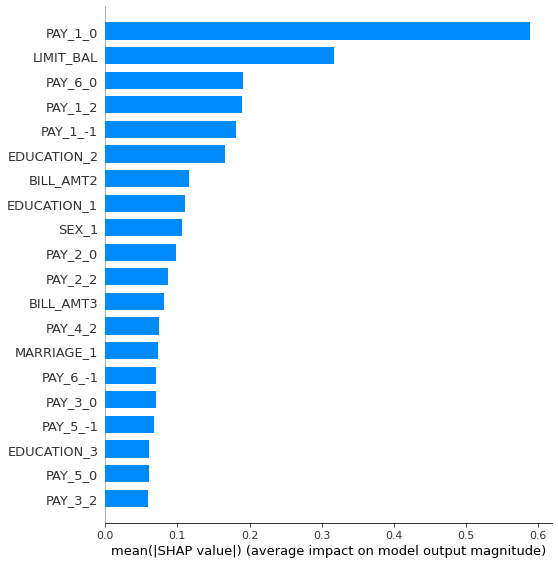

In [13]:
explainer = shap.LinearExplainer(lg_clf, ohe_X_train)
shap_values = explainer.shap_values(ohe_X_train)
dump(shap_values, 'lr_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_test, plot_type='bar')

In [111]:
np.abs(shap_values.values).mean(0)

array([0.03116119, 0.0024914 , 0.02004352, 0.00336982, 0.01460471,
       0.00613879, 0.00284589, 0.00537437, 0.02127305, 0.02240593,
       0.0089281 , 0.01429037, 0.00390303, 0.00060887, 0.00652737,
       0.        , 0.        , 0.        , 0.        , 0.00149083,
       0.        , 0.01016304, 0.        , 0.0068324 , 0.        ,
       0.02064097, 0.17802799, 0.00824493, 0.00158245, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00404784, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01790033, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00362838, 0.        , 0.02014

In [103]:
ohe_X_test.columns [np.argsort(-np.abs(shap_values.values).mean(0))][:10]

Index(['PAY_1_2', 'LIMIT_BAL', 'PAY_AMT2', 'PAY_AMT1', 'PAY_1_1', 'PAY_6_2',
       'BILL_AMT1', 'PAY_4_2', 'BILL_AMT3', 'PAY_AMT4'],
      dtype='object')

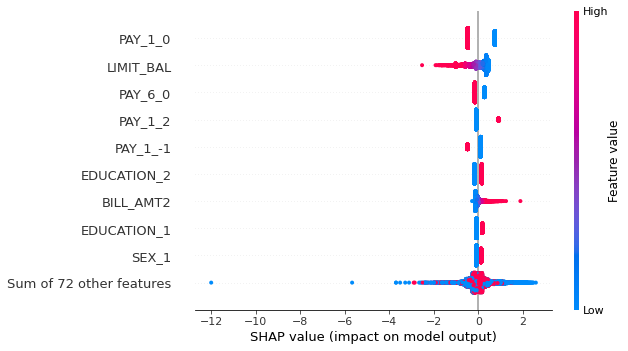

In [15]:
explainer = shap.Explainer(lg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'lr_shapbee.joblib')
shap.plots.beeswarm(shap_values)

In [16]:
choosen_instance = ohe_X_train.loc[[31]]
explainer = shap.Explainer(lg_clf, ohe_X_train)
choosen_shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, choosen_shap_values, choosen_instance)

In [29]:
selector = RFE(lg_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
lg_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in lg_rfe]
w.sort(key=lambda x: x[1])
lr_rfe = w

In [30]:
w[:10]

[('PAY_1_3', 1),
 ('PAY_1_2', 2),
 ('PAY_4_4', 3),
 ('PAY_5_2', 4),
 ('PAY_5_7', 5),
 ('PAY_2_1', 6),
 ('PAY_1_0', 7),
 ('PAY_1_-1', 8),
 ('PAY_6_3', 9),
 ('EDUCATION_4', 10)]

### Ridge Classifier

In [41]:
rg_clf = RidgeClassifier(alpha=0.5)

In [42]:
%%time
rg_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 29.4 ms, sys: 27 ms, total: 56.4 ms
Wall time: 32.3 ms


RidgeClassifier(alpha=0.5)

In [43]:
dump(rg_clf, 'rc.joblib')

['rc.joblib']

In [44]:
print(metrics.classification_report(y_train, rg_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.68      0.42      0.52      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.71     18751
weighted avg       0.81      0.82      0.81     18751



In [45]:
print(metrics.classification_report(y_test, rg_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.41      0.52      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.71      4688
weighted avg       0.81      0.82      0.80      4688



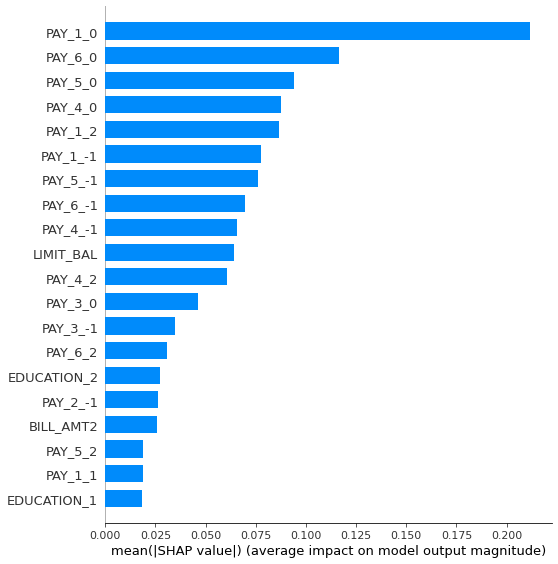

In [46]:
explainer = shap.Explainer(rg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'rc_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_test, plot_type='bar')

In [47]:
rg_shap = list(ohe_X_test.columns[np.argsort(-np.abs(shap_values.values).mean(0))])

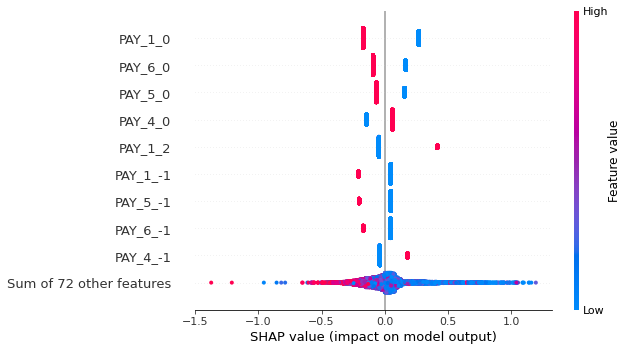

In [48]:
explainer = shap.Explainer(rg_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'rc_shapbee.joblib')
shap.plots.beeswarm(shap_values)

In [49]:
selector = RFE(rg_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
rg_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in rg_rfe]
w.sort(key=lambda x: x[1])
rg_rfe = w

In [50]:
rg_rfe[:10]

[('PAY_1_3', 1),
 ('PAY_1_2', 2),
 ('PAY_2_6', 3),
 ('PAY_1_4', 4),
 ('PAY_6_8', 5),
 ('PAY_4_1', 6),
 ('PAY_2_1', 7),
 ('PAY_1_0', 8),
 ('PAY_1_-1', 9),
 ('PAY_4_8', 10)]

### Random Forest

In [51]:
rf_clf = RandomForestClassifier(criterion='entropy', min_samples_leaf=4, n_estimators=60)

In [52]:
%%time
rf_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.61 s


RandomForestClassifier(criterion='entropy', min_samples_leaf=4, n_estimators=60)

In [53]:
dump(rf_clf, 'rf.joblib')

['rf.joblib']

In [54]:
print(metrics.classification_report(y_train, rf_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.89      0.98      0.93     14480
     default       0.91      0.58      0.70      4271

    accuracy                           0.89     18751
   macro avg       0.90      0.78      0.82     18751
weighted avg       0.89      0.89      0.88     18751



In [55]:
print(metrics.classification_report(y_test, rf_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.67      0.70      4688
weighted avg       0.80      0.82      0.80      4688



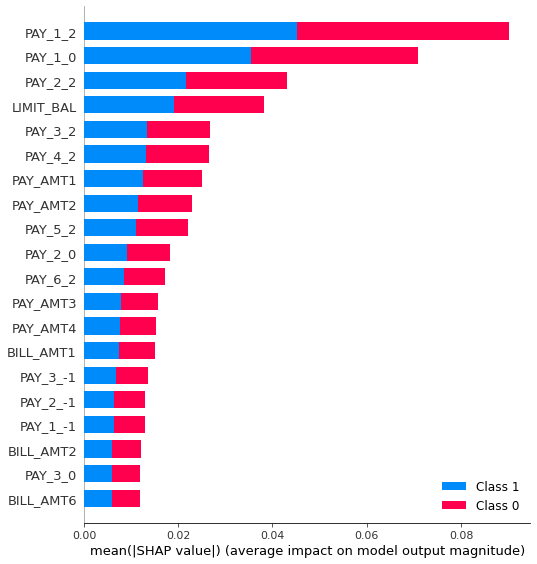

CPU times: user 25min 9s, sys: 1.71 s, total: 25min 11s
Wall time: 25min 6s


In [56]:
%%time
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(ohe_X_train)
dump(shap_values, 'rf_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_train, plot_type='bar')

In [57]:
rf_shap = list(ohe_X_test.columns[np.argsort(-np.abs(shap_values).mean(0).mean(0))])

In [45]:
%%time
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(ohe_X_train)
shap_obj = explainer(ohe_X_train)
dump(shap_obj, 'rf_shapbee.joblib')

CPU times: user 50min 11s, sys: 3.46 s, total: 50min 15s
Wall time: 50min 6s


['rf_shapbee.joblib']

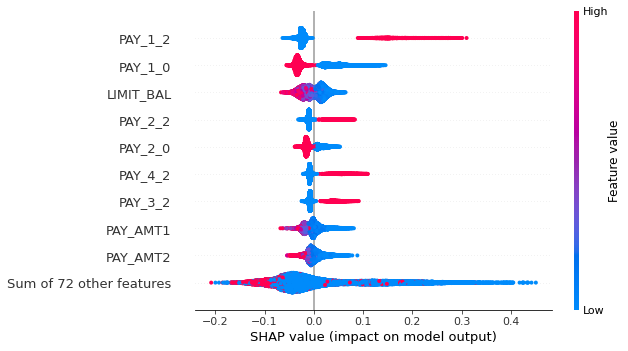

In [46]:
shap.plots.beeswarm(shap_obj[:,:,1])

In [61]:
selector = RFE(rf_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())

In [78]:
rf_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

In [82]:
w = [(i, selector.ranking_[n-1]) for i, n in rg_rfe]

In [83]:
w.sort(key=lambda x: x[1])
rf_rfe = w
rf_rfe[:10]

[('PAY_1_4', 1),
 ('PAY_1_-1', 2),
 ('PAY_1_0', 3),
 ('PAY_4_8', 4),
 ('PAY_6_0', 5),
 ('PAY_2_6', 6),
 ('PAY_4_1', 7),
 ('PAY_2_1', 8),
 ('PAY_4_6', 9),
 ('PAY_6_8', 10)]

### Adaboost

In [84]:
ab_clf = AdaBoostClassifier(learning_rate=1.3, n_estimators=60)

In [85]:
%%time
ab_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 1.93 s, sys: 0 ns, total: 1.93 s
Wall time: 1.93 s


AdaBoostClassifier(learning_rate=1.3, n_estimators=60)

In [86]:
dump(ab_clf, 'ab.joblib')

['ab.joblib']

In [87]:
print(metrics.classification_report(y_train, ab_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.67      0.42      0.51      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.68      0.70     18751
weighted avg       0.81      0.82      0.80     18751



In [88]:
print(metrics.classification_report(y_test, ab_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.95      0.89      3574
     default       0.71      0.40      0.51      1114

    accuracy                           0.82      4688
   macro avg       0.77      0.68      0.70      4688
weighted avg       0.81      0.82      0.80      4688



In [89]:
explainer = shap.Explainer(ab_clf.predict, ohe_X_test)

In [90]:
%%time
shap_values = explainer(ohe_X_train)
dump(shap_values, 'ab_shapbars.joblib')
dump(shap_values, 'ab_shapbee.joblib')

Permutation explainer: 18752it [2:01:51,  2.56it/s]                             


CPU times: user 2h 1min 19s, sys: 8.33 s, total: 2h 1min 27s
Wall time: 2h 1min 52s


['ab_shapbee.joblib']

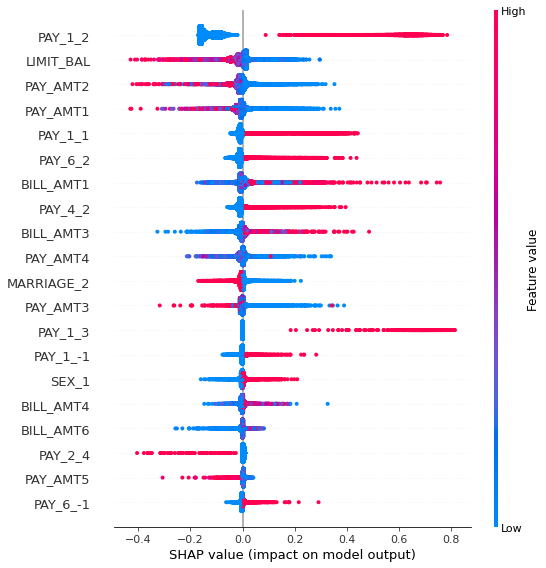

In [91]:
shap.summary_plot(shap_values, ohe_X_train)

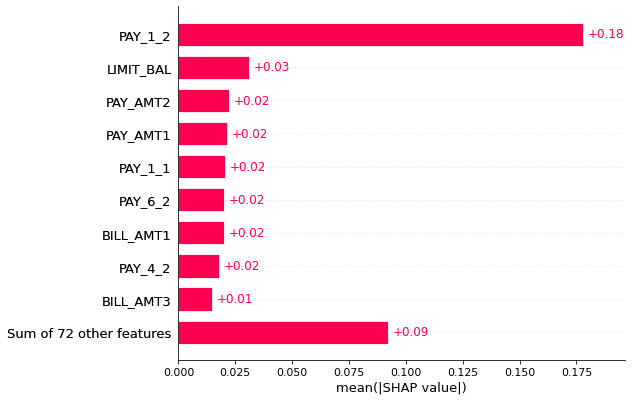

In [92]:
shap.plots.bar(shap_values)

In [95]:
selector = RFE(ab_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
ab_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in ab_rfe]
w.sort(key=lambda x: x[1])
ab_rfe = w
ab_rfe

[('PAY_AMT1', 1),
 ('PAY_AMT2', 2),
 ('BILL_AMT3', 3),
 ('BILL_AMT1', 4),
 ('PAY_AMT3', 5),
 ('PAY_AMT4', 6),
 ('LIMIT_BAL', 7),
 ('BILL_AMT4', 8),
 ('PAY_1_1', 9),
 ('PAY_1_2', 10),
 ('PAY_1_3', 11),
 ('PAY_4_2', 12),
 ('PAY_1_4', 13),
 ('MARRIAGE_2', 14),
 ('EDUCATION_4', 15),
 ('SEX_1', 16),
 ('BILL_AMT6', 17),
 ('PAY_1_-1', 18),
 ('BILL_AMT5', 19),
 ('BILL_AMT2', 20),
 ('AGE', 21),
 ('PAY_2_4', 22),
 ('PAY_6_2', 23),
 ('PAY_6_3', 24),
 ('PAY_6_-1', 25),
 ('PAY_AMT5', 26),
 ('PAY_AMT6', 27),
 ('PAY_2_8', 28),
 ('PAY_3_-1', 29),
 ('PAY_3_3', 30),
 ('PAY_5_4', 31),
 ('PAY_5_5', 32),
 ('PAY_5_6', 33),
 ('PAY_5_7', 34),
 ('PAY_5_8', 35),
 ('PAY_6_0', 36),
 ('PAY_3_0', 37),
 ('PAY_1_0', 38),
 ('PAY_3_1', 39),
 ('PAY_3_2', 40),
 ('PAY_5_2', 41),
 ('PAY_5_3', 42),
 ('PAY_3_4', 43),
 ('MARRIAGE_3', 44),
 ('PAY_3_5', 45),
 ('PAY_5_0', 46),
 ('PAY_3_6', 47),
 ('PAY_3_7', 48),
 ('PAY_5_-1', 49),
 ('PAY_1_5', 50),
 ('PAY_4_8', 51),
 ('PAY_1_6', 52),
 ('PAY_4_7', 53),
 ('PAY_1_7', 54),
 ('PAY_4_

In [113]:
list(ohe_X_test.columns[np.argsort(-np.abs(shap_values.values).mean(0))])

['PAY_1_2',
 'LIMIT_BAL',
 'PAY_AMT2',
 'PAY_AMT1',
 'PAY_1_1',
 'PAY_6_2',
 'BILL_AMT1',
 'PAY_4_2',
 'BILL_AMT3',
 'PAY_AMT4',
 'MARRIAGE_2',
 'PAY_AMT3',
 'PAY_1_3',
 'PAY_1_-1',
 'SEX_1',
 'BILL_AMT4',
 'BILL_AMT6',
 'PAY_2_4',
 'PAY_AMT5',
 'PAY_6_-1',
 'BILL_AMT2',
 'BILL_AMT5',
 'AGE',
 'PAY_1_4',
 'PAY_6_3',
 'EDUCATION_4',
 'PAY_AMT6',
 'PAY_4_1',
 'PAY_4_8',
 'PAY_4_-1',
 'PAY_4_3',
 'PAY_4_4',
 'PAY_4_5',
 'PAY_4_6',
 'PAY_4_7',
 'PAY_4_0',
 'PAY_6_5',
 'PAY_5_4',
 'PAY_5_0',
 'PAY_5_2',
 'PAY_5_3',
 'PAY_6_6',
 'PAY_5_5',
 'PAY_5_6',
 'PAY_5_7',
 'PAY_5_8',
 'PAY_3_8',
 'PAY_6_0',
 'PAY_6_4',
 'PAY_5_-1',
 'PAY_3_7',
 'PAY_2_6',
 'PAY_3_5',
 'SEX_2',
 'EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'MARRIAGE_1',
 'MARRIAGE_3',
 'PAY_1_0',
 'PAY_1_5',
 'PAY_1_6',
 'PAY_1_7',
 'PAY_1_8',
 'PAY_2_-1',
 'PAY_3_6',
 'PAY_2_0',
 'PAY_2_2',
 'PAY_2_3',
 'PAY_2_5',
 'PAY_6_7',
 'PAY_2_7',
 'PAY_2_8',
 'PAY_3_-1',
 'PAY_3_0',
 'PAY_3_1',
 'PAY_3_2',
 'PAY_3_3',
 'PAY_3_4',
 'PAY_2_1

## LDA

In [115]:
lda_clf = LinearDiscriminantAnalysis(solver='svd', tol=1e-05)

In [116]:
%%time
lda_clf.fit(ohe_X_train, y_train.values.ravel());

CPU times: user 515 ms, sys: 68 ms, total: 583 ms
Wall time: 354 ms


LinearDiscriminantAnalysis(tol=1e-05)

In [117]:
dump(lda_clf, 'lda.joblib')

['lda.joblib']

In [118]:
print(metrics.classification_report(y_train, lda_clf.predict(ohe_X_train), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.85      0.94      0.89     14480
     default       0.67      0.44      0.53      4271

    accuracy                           0.82     18751
   macro avg       0.76      0.69      0.71     18751
weighted avg       0.81      0.82      0.81     18751



In [119]:
print(metrics.classification_report(y_test, lda_clf.predict(ohe_X_test), target_names=['paid', 'default']))

              precision    recall  f1-score   support

        paid       0.84      0.94      0.89      3574
     default       0.68      0.42      0.52      1114

    accuracy                           0.82      4688
   macro avg       0.76      0.68      0.70      4688
weighted avg       0.80      0.82      0.80      4688



In [120]:
explainer = shap.Explainer(lda_clf.predict, ohe_X_test)

Permutation explainer: 18752it [12:40, 24.31it/s]                           


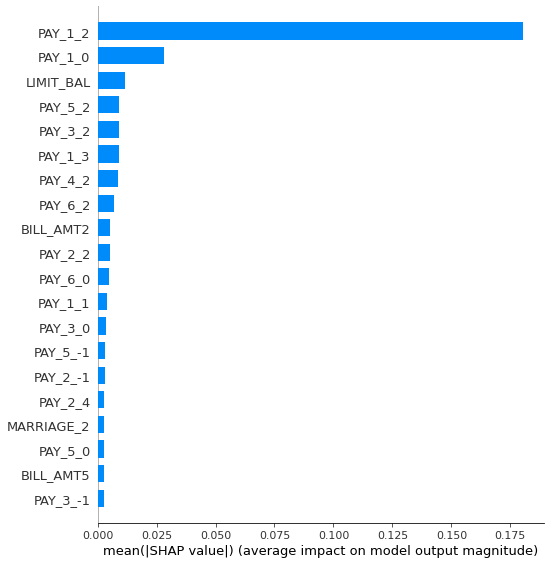

In [121]:
shap_values = explainer(ohe_X_train)
dump(shap_values, 'lda_shapbars.joblib')
shap.summary_plot(shap_values, ohe_X_test, plot_type='bar')

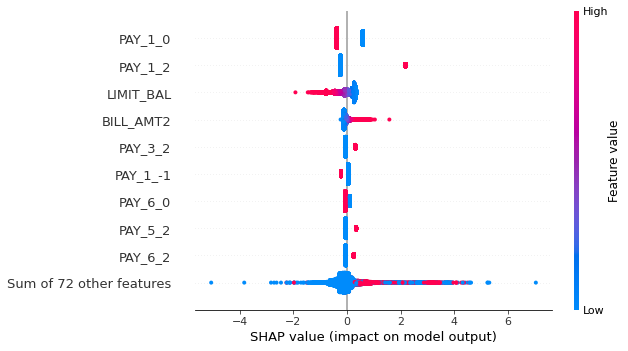

In [122]:
explainer = shap.Explainer(lda_clf, ohe_X_train)
shap_values = explainer(ohe_X_train)
dump(shap_values, 'lda_shapbee.joblib')
shap.plots.beeswarm(shap_values)

In [123]:
selector = RFE(lda_clf, n_features_to_select=1, step=1)
selector = selector.fit(ohe_X_train, y_train.values.ravel())
lda_rfe = zip(range(ohe_X_train.shape[1]), ohe_X_train.columns)

w = [(n, selector.ranking_[i]) for i, n in lda_rfe]
w.sort(key=lambda x: x[1])
lda_rfe = w
lda_rfe

[('PAY_6_8', 1),
 ('PAY_1_3', 2),
 ('PAY_2_6', 3),
 ('PAY_1_2', 4),
 ('PAY_4_8', 5),
 ('PAY_5_6', 6),
 ('PAY_5_7', 7),
 ('PAY_4_7', 8),
 ('PAY_4_6', 9),
 ('PAY_2_8', 10),
 ('PAY_1_4', 11),
 ('PAY_3_6', 12),
 ('PAY_1_8', 13),
 ('PAY_4_1', 14),
 ('PAY_2_1', 15),
 ('PAY_5_8', 16),
 ('PAY_1_0', 17),
 ('PAY_1_-1', 18),
 ('PAY_4_5', 19),
 ('PAY_6_3', 20),
 ('PAY_5_5', 21),
 ('PAY_5_2', 22),
 ('PAY_2_5', 23),
 ('PAY_3_3', 24),
 ('PAY_3_7', 25),
 ('PAY_3_2', 26),
 ('PAY_4_4', 27),
 ('PAY_3_5', 28),
 ('PAY_3_1', 29),
 ('PAY_1_7', 30),
 ('PAY_3_8', 31),
 ('PAY_6_5', 32),
 ('EDUCATION_4', 33),
 ('PAY_2_4', 34),
 ('PAY_2_-1', 35),
 ('PAY_6_6', 36),
 ('PAY_1_5', 37),
 ('PAY_6_2', 38),
 ('PAY_4_2', 39),
 ('PAY_5_4', 40),
 ('PAY_6_4', 41),
 ('PAY_1_1', 42),
 ('PAY_1_6', 43),
 ('LIMIT_BAL', 44),
 ('MARRIAGE_2', 45),
 ('PAY_2_7', 46),
 ('PAY_6_7', 47),
 ('PAY_3_-1', 48),
 ('PAY_3_4', 49),
 ('PAY_3_0', 50),
 ('PAY_6_0', 51),
 ('BILL_AMT2', 52),
 ('SEX_2', 53),
 ('PAY_2_2', 54),
 ('PAY_5_3', 55),
 ('PAY_